<center><img src="https://is1-ssl.mzstatic.com/image/thumb/Purple122/v4/05/e7/67/05e76784-3364-b535-7e20-b3f4946a56b6/AppIcon-0-0-1x_U007emarketing-0-0-0-7-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/434x0w.webp" style="height:150px"></center>

<hr style="border-width:2px;border-color:red">
<center><h1>Test Technique Data Scientist</h1></center>
<center><h2> Mesure de la dérive </h2></center>
<hr style="border-width:2px;border-color:red">

# Contexte

La **dérive** en apprentissage automatique (ou **"drift"** en anglais) fait référence à un **changement dans les données d'entrée ou de sortie d'un modèle** de machine learning **après son entraînement initial**. Cela peut se produire lorsque les données utilisées pour entraîner le modèle ne **reflètent plus la réalité**, ou lorsque **les conditions du problème changent de manière significative**.

La dérive des données peut affecter la précision du modèle de manière significative et peut entraîner des erreurs coûteuses dans les prévisions ou les décisions basées sur le modèle. Par conséquent, **il est important de surveiller régulièrement les performances du modèle** et de le mettre à jour en fonction des nouveaux jeux de données ou des nouvelles conditions du problème.

# Objectif

Dans ce test, vous allez implémenter des métriques permettant de mesurer la dérive d'un modèle dans un usecase de **e-commerce** où nous essayons de prédire le **panier total** (variable **`TotalCart`** : chiffre d'affaire total d'un client sur la période donnée) des clients en fonction des variables suivantes:
* **`Age`** : âge du client en années.
* **`Seniority`** : ancienneté du client en années.
* **`Orders`** : Nombre de commandes effectuées sur la période précédente.
* **`Items`** : Nombre d'items commandés sur la période précédente.
* **`AverageDiscount`** : Réduction moyenne accordée au client sur la période précédente en pourcentage.
* **`TopCategory`** : Catégorie de produits favorite du client.
* **`BrowsingTime`** : Temps total passé sur le site web sur la période précédente en secondes.
* **`EmailsOpened`** : Nombre de mails marketing ouverts par le client sur la période précédente.
* **`SupportInteractions`** : Nombre d'interactions que le client a eu avec le service client sur la période précédente.

Le jeu de données est décomposé en 4 périodes correspondant aux 4 trimestres de l'année 2022. Vous trouverez les données correspondant à chaque période dans les fichiers **`period_0.csv`**, **`period_1.csv`**, ..., **`period_3.csv`**.

Vous allez d'abord **entraîner et évaluer un modèle de machine learning** sur les données de la **période 0**. On supposera que ce modèle sera utilisé pour effectuer les prédictions de panier total sur toute l'année 2022.

Ensuite, vous devrez **implémenter des métriques de dérive** qui vous seront données et **effectuer une analyse** de celle-ci.

# Entraînement du modèle

* **Entraînez et validez** deux ou trois modèles de votre choix sur les données de la période 0. 

**Conseils**

* Vous serez évalué sur votre **rigueur** et non sur les performances du modèle.


* Il n'est pas nécessaire de faire une analyse exploratoire des données.


* Il n'est pas nécessaire de faire de recherche d'hyperparamètres optimaux non plus mais vous pouvez le faire si vous le souhaitez.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

from dmba import stepwise_selection, AIC_score

In [3]:
df0=pd.read_csv('period_0.csv')
df0.head()

,Age,Seniority,Orders,Items,AverageDiscount,TopCategory,BrowsingTime,EmailsOpened,SupportInteractions,TotalCart
0,21,2,4,7,0.14,"Clothing,Shoes & Jewelry",68.473629,3,2,34.00
1,22,0,4,5,0.50,Toys & Games,29.258063,1,0,28.28
2,22,1,2,6,0.37,"Health, Household & Baby Care",11.515517,0,0,19.33
3,19,0,2,8,0.60,Toys & Games,74.495861,1,0,26.83
4,25,1,1,5,0.58,Toys & Games,1.682705,2,1,17.67


In [4]:
print('Shape:',df0.shape)
df0.dtypes

Shape: (1000, 10)


Age                      int64
Seniority                int64
Orders                   int64
Items                    int64
AverageDiscount        float64
TopCategory             object
BrowsingTime           float64
EmailsOpened             int64
SupportInteractions      int64
TotalCart              float64
dtype: object

In [5]:
d={i:df0[i].isna().sum() for i in df0.columns}
pd.DataFrame(list(d.items()), columns=['variable', 'Nombre des valeurs manquantes'])

,variable,Nombre des valeurs manquantes
0,Age,0
1,Seniority,0
2,Orders,0
3,Items,0
4,AverageDiscount,0
5,TopCategory,0
6,BrowsingTime,0
7,EmailsOpened,0
8,SupportInteractions,0
9,TotalCart,0


In [6]:
print(df0['TopCategory'].unique())
df0.describe()

['Clothing,Shoes & Jewelry' 'Toys & Games' 'Health, Household & Baby Care'
 'Electronics' 'Home & Kitchen' 'Pet Supplies' 'Beauty & Personal Care'
 'Sports & outdoors' 'Office Supplies']


,Age,Seniority,Orders,Items,AverageDiscount,BrowsingTime,EmailsOpened,SupportInteractions,TotalCart
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.06900,0.508000,3.011000,5.975000,0.371700,97.949068,0.989000,1.012000,35.884260
std,5.05943,0.720038,1.731438,2.399194,0.219133,100.222845,1.002938,1.022204,17.619171
min,7.00000,0.000000,0.000000,1.000000,0.000000,0.012724,0.000000,0.000000,0.000000
25%,21.00000,0.000000,2.000000,4.000000,0.180000,29.333357,0.000000,0.000000,25.575000
50%,24.00000,0.000000,3.000000,6.000000,0.380000,68.037177,1.000000,1.000000,33.655000
75%,27.00000,1.000000,4.000000,7.000000,0.560000,127.063901,2.000000,2.000000,43.772500
max,41.00000,4.000000,9.000000,15.000000,0.750000,831.026761,5.000000,7.000000,138.880000


Il est important de vérifier si les variables sont indépendantes les unes des autres avant d'utiliser un modèle de machine learning. Cela peut aider à éviter des problèmes tels que la colinéarité, qui peut rendre les résultats du modèle peu fiables.

Pour vérifier si les variables sont indépendantes, on peut utiliser la matrice de corrélation. Si deux variables sont fortement corrélées, cela peut indiquer une dépendance entre elles. 

<AxesSubplot:>

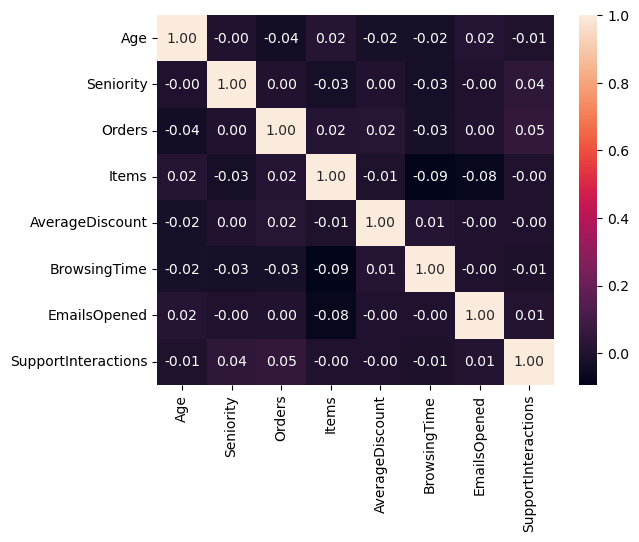

In [7]:
features = ['Age', 'Seniority', 'Orders', 'Items', 'AverageDiscount', 'BrowsingTime', 'EmailsOpened', 'SupportInteractions']

corr_matrix=df0[features].corr()


# Affichage de la matrice de corrélation
sns.heatmap(corr_matrix, annot=True, fmt='.2f')

En observant les résultats de la matrice de corrélation, on constate que la valeur maximale est de 0,05, ce qui est assez faible. Cela suggère qu'il n'y a pas de corrélation forte entre les différentes caractéristiques étudiées, ce qui est une bonne nouvelle pour la mise en place de modèles de prédiction. L'indépendance des caractéristiques est importante pour éviter la redondance et la confusion dans la modélisation et pour garantir que chaque caractéristique apporte une information unique à la prédiction de la variable cible. Ainsi, nous pouvons maintenant passer à l'étape suivante, qui consiste à implémenter différents modèles pour prédire la variable TotalCart en utilisant ces caractéristiques.

### Modèle 1: Régression Linéaire

Le modèle de régression est bien adapté à ce projet car la variable cible (TotalCart) est une variable continue, ce qui signifie qu'elle peut prendre une infinité de valeurs dans une plage donnée. De plus, la régression permet de modéliser la relation entre une variable cible et plusieurs variables explicatives (dans ce cas, Age, Seniority, Orders, Items, AverageDiscount, TopCategory, BrowsingTime, EmailsOpened et SupportInteractions) afin de prédire la valeur de la variable cible en fonction des valeurs des variables explicatives.

La régression linéaire est un bon modèle car elle est simple, facile à interpréter et peut être utilisée pour évaluer la relation entre une variable dépendante (**`TotalCart`**)  et plusieurs variables indépendantes continues. 

Les modèles de régression linéaire nécessitent que toutes les variables explicatives soient numériques. Alors la variable catégorielle **`TopCategory`** , doit donc être transformées en variables binaires pour être utilisées dans le modèle.

Ainsi, la transformation de la variable catégorielle  **`TopCategory`**  en variables binaires permettra de l'inclure dans notre ensemble de caractéristiques et d'améliorer la performance de notre modèle de régression.

In [8]:
# Sélectionner les variables indépendantes (caractéristiques)
predictors=['Age', 'Seniority', 'Orders', 'Items', 'AverageDiscount','TopCategory', 'BrowsingTime', 'EmailsOpened', 'SupportInteractions']

# Comme TopCategory est Catégoriel #Type Object on doit 
X=pd.get_dummies(df0[predictors],drop_first=True)

X.dtypes

Age                                            int64
Seniority                                      int64
Orders                                         int64
Items                                          int64
AverageDiscount                              float64
BrowsingTime                                 float64
EmailsOpened                                   int64
SupportInteractions                            int64
TopCategory_Clothing,Shoes & Jewelry           uint8
TopCategory_Electronics                        uint8
TopCategory_Health, Household & Baby Care      uint8
TopCategory_Home & Kitchen                     uint8
TopCategory_Office Supplies                    uint8
TopCategory_Pet Supplies                       uint8
TopCategory_Sports & outdoors                  uint8
TopCategory_Toys & Games                       uint8
dtype: object

In [9]:
df0['TopCategory'].nunique()

9

On remarque qu'à la place de la variable 'TopCategory' on a 8 variables numériques: 

'TopCategory_Clothing,Shoes & Jewelry', 'TopCategory_Electronics', 'TopCategory_Health, Household & Baby Care', 'TopCategory_Home & Kitchen', 'TopCategory_Office Supplies', 'TopCategory_Pet Supplies', 'TopCategory_Sports & outdoors', 'TopCategory_Toys & Games'.

( 8 = Nombre des valeurs uniques de la variable **`TopCategory`** - 1 )

<b>Remarque:</b>
Par défaut, Pandas crée N variables indicatrices pour toutes les modalités de la variable d'origine. Cela signifie que l'une des variables indicatrices sera linéairement dépendante des autres variables indicatrices. Cette redondance peut causer des problèmes dans certains modèles de Machine Learning, en particulier avec les modèles de régression linéaire, car elle peut entraîner une mauvaise estimation des coefficients.

Avec <b>drop_first=True</b>, la première variable indicatrice pour la première modalité de la variable catégorielle est supprimée, évitant ainsi la redondance. De cette façon, le nombre de variables créées est égal au nombre de modalités moins un.

In [10]:
# Sélectionner la variable dépendante (cible)
y = df0['TotalCart']

# Créer un objet de modèle de régression linéaire
lr = LinearRegression()

# Adapter le modèle aux données d'entraînement
lr.fit(X, y)

LinearRegression()

#### Evaluation du modèle:

In [11]:
print(f'Intercept: {lr.intercept_:.3f}')
print('\nCoefficients:\n')
pd.DataFrame({"Variables":X.columns,"coef":lr.coef_}).rename(columns={X.columns[0]: "Variable"})

Intercept: -5.229

Coefficients:



,Variables,coef
0,Age,0.588468
1,Seniority,-0.136806
2,Orders,4.739969
3,Items,0.140615
4,AverageDiscount,-0.489526
5,BrowsingTime,0.134803
6,EmailsOpened,0.086694
7,SupportInteractions,-0.051586
8,"TopCategory_Clothing,Shoes & Jewelry",-2.026787
9,TopCategory_Electronics,-1.538799


In [12]:
fitted = lr.predict(X)
RMSE = np.sqrt(mean_squared_error(df0['TotalCart'], fitted))
r2 = r2_score(df0['TotalCart'], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 8
r2: 0.7965


Le RMSE (Root Mean Squared Error) de 8 signifie que les prédictions de notre modèle de régression sont en moyenne écartées de 8 unités de la variable cible (TotalCart) par rapport aux valeurs réelles. Ce score n'est pas trop élevé, ce qui indique que le modèle peut être considéré comme relativement précis.

Le R2 de 0.7965 signifie que le modèle de régression explique environ 80% de la variation dans la variable cible (TotalCart). Cela indique que le modèle est assez performant pour prédire la variable cible, mais il peut encore y avoir de l'incertitude ou du bruit dans les données qui ne peuvent pas être expliqués par les variables indépendantes.

##### Stepwise Selection:

Le Stepwise Selection est une technique de sélection de variables qui permet d'identifier les variables les plus importantes dans un modèle de régression. En utilisant cette technique, nous pouvons éliminer les variables qui ont peu d'impact sur la prédiction de la variable cible, ce qui peut améliorer la performance du modèle. Nous allons donc utiliser cette technique pour essayer d'améliorer notre modèle de régression et obtenir de meilleures prédictions pour la variable TotalCart.

In [13]:
# A function that returns a fitted model for a given set of variables
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

# A function returns a score for a given model and a set of variables
# 'AIC_score' is taken from the package dmba
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_Linear_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()

print(f'Intercept: {best_Linear_model.intercept_:.3f}')
print('\nCoefficients:')
pd.DataFrame({"Variables":best_variables,"coef":best_Linear_model.coef_})

Variables: Age, Seniority, Orders, Items, AverageDiscount, BrowsingTime, EmailsOpened, SupportInteractions, TopCategory_Clothing,Shoes & Jewelry, TopCategory_Electronics, TopCategory_Health, Household & Baby Care, TopCategory_Home & Kitchen, TopCategory_Office Supplies, TopCategory_Pet Supplies, TopCategory_Sports & outdoors, TopCategory_Toys & Games
Start: score=8578.85, constant
Step: score=7775.51, add BrowsingTime
Step: score=7139.53, add Orders
Step: score=7011.53, add Age
Step: score=7009.98, add TopCategory_Clothing,Shoes & Jewelry
Step: score=7008.38, add TopCategory_Home & Kitchen
Step: score=7007.07, add TopCategory_Office Supplies
Step: score=7006.41, add TopCategory_Pet Supplies
Step: score=7006.41, unchanged None

Intercept: -5.195

Coefficients:


,Variables,coef
0,BrowsingTime,0.134608
1,Orders,4.749380
2,Age,0.592020
3,"TopCategory_Clothing,Shoes & Jewelry",-1.540561
4,TopCategory_Home & Kitchen,-1.438985
5,TopCategory_Office Supplies,-8.592136
6,TopCategory_Pet Supplies,-4.400474


In [14]:
fitted = best_Linear_model.predict(X[best_variables])

RMSE = np.sqrt(mean_squared_error(df0['TotalCart'], fitted))
r2 = r2_score(df0['TotalCart'], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 8
r2: 0.7953


Après avoir effectué une sélection de caractéristiques en utilisant le stepwise, nous avons constaté que les résultats n'étaient pas meilleurs que le modèle initial avec toutes les variables. Par conséquent, il n'est pas nécessaire de supprimer certaines variables. Nous utiliserons donc le modèle initial comme notre modèle de regression linéaire pour ce test.

### Modèle 2: Random Forest Regression

Decision Tree Regression est un bon modèle pour notre projet pour plusieurs raisons. Tout d'abord, ce modèle est capable de gérer des données avec des relations complexes et non-linéaires entre les caractéristiques et la variable cible, ce qui est important pour notre ensemble de données. De plus, les arbres de décision sont capables de gérer des caractéristiques qualitatives et quantitatives, ce qui est utile car notre ensemble de caractéristiques contient une variable catégorielle **`TopCategory`**. 

Le Random Forest Regression peut être considéré comme une extension de la decision tree regression. Il utilise une combinaison de plusieurs arbres de décision pour améliorer la précision des prévisions. En général, Random Forest Regression a tendance à offrir des performances supérieures à la decision tree regression en raison de sa capacité à réduire le surajustement (overfitting)

In [15]:
# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle
rf_model = RandomForestRegressor(random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Calculer les métriques de performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 2.1806939240640797
R2: 0.9803668074375267


Le résultat de la performance du modèle de Random Forest Regression est très satisfaisant. En effet, le RMSE (Root Mean Squared Error) de 2.18 indique que les prédictions ont une erreur moyenne de seulement 2.18 unités par rapport aux valeurs réelles. De plus, le R2 (coefficient de détermination) de 0.98 indique que le modèle explique 98% de la variance totale des données, ce qui est un excellent résultat. 

Il est important de noter que même si les résultats du modèle avec les hyperparamètres par défaut sont très bons, cela ne signifie pas nécessairement que ces hyperparamètres sont optimaux pour le modèle. Les hyperparamètres optimaux peuvent différer si les ensembles d'entraînement et de test diffèrent.

Ainsi, On va utiliser une approche de validation croisée <b>GridSearchCV</b> pour estimer les performances du modèle et sélectionner les hyperparamètres optimaux. De cette façon, chaque échantillon de données est utilisé à la fois pour l'entraînement et la validation, ce qui réduit le risque de surajustement du modèle à des données spécifiques. En utilisant cette approche, on peut être plus confiant que les hyperparamètres choisis fonctionnent bien pour les données en général, plutôt que d'être simplement adaptés aux données d'entraînement spécifiques.

In [16]:
# pour determiner les hyperparamètres de RandomForestRegressor.
#help(RandomForestRegressor)

In [16]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialiser le modèle
rf_model = RandomForestRegressor(random_state=42)

# Effectuer une recherche sur grille pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Utiliser les meilleurs hyperparamètres pour entraîner le modèle sur l'ensemble d'entraînement
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test avec le modèle entraîné avec les meilleurs hyperparamètres
y_pred = best_rf_model.predict(X_test)

# Calculer les métriques de performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)
print("Meilleurs hyperparamètres:", grid_search.best_params_)

RMSE: 4.203894062685201
R2: 0.9270366063051854
Meilleurs hyperparamètres: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [17]:
rf_model = RandomForestRegressor(max_depth= 20, max_features='sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators=50)

<b>NB:</b> Si vous testez la performance de Random Forest après l'optimisation des hyperparamètres, vous pourriez constater une diminution du R2 et une augmentation du RMSE. Ceci peut s'expliquer par le fait qu'on a pas utilisé GridSearch pour tous les hyperparamètres, car cela peut prendre beaucoup de temps. Notre but était simplement de faire une optimisation indicative et on a pas pu faire une recherche extensive sur un plus grand nombre d'hyperparamètres en raison de la contrainte de temps nécessaire pour obtenir des résultats.

### Modèle 3: KNN Regression

Le modèle KNN (K-Nearest Neighbors) peut être utile pour notre projet de prédiction du panier total des clients. Le modèle KNN utilise les caractéristiques des clients pour les classer en groupes en fonction de leur proximité les uns avec les autres. Ensuite, lorsque de nouveaux clients sont ajoutés, ils sont classés dans l'un de ces groupes en fonction de leurs caractéristiques similaires. Ce modèle peut être particulièrement utile pour notre projet car il peut prendre en compte les relations complexes entre les variables et peut être utilisé pour prédire des valeurs continues telles que le panier total des clients.

Cependant, <b>il est important de noter que KNN n'est pas normalement utilisé pour prédire des valeurs numériques</b>. En effet, ce modèle est souvent utilisé pour la classification et la prédiction de valeurs catégorielles. Néanmoins, il serait intéressant de voir comment KNN calcule les moyennes et prédit des valeurs numériques dans le cadre de ce test.

<b>RQ:</b> De même pour Random Forest. 

In [18]:
# Initialisation du modèle KNN avec un k = 7 (randomly chosen) 
knn = KNeighborsRegressor(n_neighbors=7)

# Entraînement du modèle sur les données d'entraînement
knn.fit(X_train, y_train)

# Prédiction des valeurs sur les données de test
y_pred = knn.predict(X_test)

# Calcul de la racine carrée de l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 5.907296887782784
R2: 0.8559281624756082


Les résultats obtenus sont plutôt satisfaisants, avec un RMSE de 5.27 et un R2 de 0.88. Cependant, il est toujours important  d'essayer d'optimiser le choix des hyperparamètres pour améliorer encore les performances du modèle.

Alors, on va utiliser <b>GridSearchCV</b> pour optimiser les paramètres comme avant.

In [19]:
# pour determiner les hyperparamètres de KNN.
#help(KNeighborsRegressor)

In [20]:
knn = KNeighborsRegressor()

# Définir les hyperparamètres à optimiser
param_grid = {'n_neighbors': range(0,15),
              'weights': ['uniform', 'distance'],
              'p': [1, 2]} #1 equivalent to using manhattan_distance, and 2 euclidean_distance

# Appliquer GridSearchCV pour trouver les hyperparamètres optimaux
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Afficher les hyperparamètres optimaux
print("Hyperparamètres optimaux :", grid_search.best_params_)

Hyperparamètres optimaux : {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


C:\Users\Youssef\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Youssef\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Youssef\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", line 213, in fit
    return self._fit(X, y)
  File "C:\Users\Youssef\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbor

In [20]:
knn = KNeighborsRegressor(n_neighbors= 5, p= 1,weights='uniform')

* **Entrainez votre modèle sur toute la période 0** puis **testez votre modèle** sur les données des **périodes 1, 2 et 3**. Comment évolue la performance du modèle?

In [21]:
df1=pd.read_csv('period_1.csv')
df2=pd.read_csv('period_2.csv')
df3=pd.read_csv('period_3.csv')

In [22]:
print("Number of empty values in period_1 =",df1.isna().sum().sum())
print("Number of empty values in period_2 =",df2.isna().sum().sum())
print("Number of empty values in period_3 =",df3.isna().sum().sum())

# On s'assure que tout les datasets on les mêmes atributs.
if (list(df0.columns)==list(df1.columns)==list(df2.columns)==list(df3.columns)):
    print("Tout les datasets on les mêmes colonnes.")

# De même pour leurs types.
if (list(df0.dtypes.values)==list(df1.dtypes.values)==list(df2.dtypes.values)==list(df3.dtypes.values)):
    print("Tout les datasets on les mêmes dtypes.")

Number of empty values in period_1 = 0
Number of empty values in period_2 = 0
Number of empty values in period_3 = 0
Tout les datasets on les mêmes colonnes.
Tout les datasets on les mêmes dtypes.


### Modèle 1: Régression Linéaire

Dans notre cas, nous avons entraîné déjà le modèle de régression linéaire en utilisant toutes les données disponibles de la periode_0. Maintenant que notre modèle est entraîné, nous pouvons l'utiliser pour prédire les valeurs de la variable cible pour les données de la période 1, période 2 et période 3.

#### Period_1

In [23]:
X=pd.get_dummies(df1[predictors],drop_first=True)

fitted = lr.predict(X)

RMSE = np.sqrt(mean_squared_error(df1['TotalCart'], fitted))

r2 = r2_score(df1['TotalCart'], fitted)

print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 9
r2: 0.7453


#### Period_2

In [24]:
X=pd.get_dummies(df2[predictors],drop_first=True)

fitted = lr.predict(X)

RMSE = np.sqrt(mean_squared_error(df2['TotalCart'], fitted))

r2 = r2_score(df2['TotalCart'], fitted)

print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 11
r2: 0.7106


#### Period_3

In [25]:
X=pd.get_dummies(df3[predictors],drop_first=True)

fitted = lr.predict(X)

RMSE = np.sqrt(mean_squared_error(df3['TotalCart'], fitted))

r2 = r2_score(df3['TotalCart'], fitted)

print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 15
r2: 0.5632


#### Combinaison des 3 datasets

In [26]:
combined_df = pd.concat([df1, df2, df3]).reset_index()
combined_df.tail()

,index,Age,Seniority,Orders,Items,AverageDiscount,TopCategory,BrowsingTime,EmailsOpened,SupportInteractions,TotalCart
2995,995,28,2,1,2,0.38,"Clothing,Shoes & Jewelry",202.370990,1,3,36.73
2996,996,29,1,3,5,0.48,"Clothing,Shoes & Jewelry",552.845632,0,2,95.77
2997,997,35,0,4,3,0.53,"Clothing,Shoes & Jewelry",61.824173,2,0,30.47
2998,998,25,3,4,3,0.78,Sports & outdoors,31.961986,0,1,17.26
2999,999,27,0,0,4,0.24,Electronics,152.540018,1,1,0.00


In [27]:
X=pd.get_dummies(combined_df[predictors],drop_first=True)

fitted = lr.predict(X)

rmse_lr_tot = np.sqrt(mean_squared_error(combined_df['TotalCart'], fitted))

r2_lr_tot = r2_score(combined_df['TotalCart'], fitted)

print(f'RMSE: {rmse_lr_tot:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 12
r2: 0.5632


### Modèle 2: Random Forest Regression

Nous allons entraîner notre modèle de Random Forest Regression sur l'ensemble des données disponibles de la period_0.

In [28]:
X_train=pd.get_dummies(df0[predictors],drop_first=True)
y_train=df0['TotalCart']
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=50)

#### period_1

In [29]:
X_test=pd.get_dummies(df1[predictors],drop_first=True)

y_test=df1['TotalCart']

y_pred_RF_1 = rf_model.predict(X_test)

# Calculer les métriques de performance
rmse = mean_squared_error(y_test, y_pred_RF_1, squared=False)
r2 = r2_score(y_test, y_pred_RF_1)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 9.262671966254858
R2: 0.757067758452602


#### period_2

In [30]:
X_test=pd.get_dummies(df2[predictors],drop_first=True)

y_test=df2['TotalCart']

y_pred_RF_2 = rf_model.predict(X_test)

# Calculer les métriques de performance
rmse = mean_squared_error(y_test, y_pred_RF_2, squared=False)
r2 = r2_score(y_test, y_pred_RF_2)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 10.253613429958717
R2: 0.7253380104415299


#### period_3

In [31]:
X_test=pd.get_dummies(df3[predictors],drop_first=True)

y_test=df3['TotalCart']

y_pred_RF_3 = rf_model.predict(X_test)

# Calculer les métriques de performance
rmse = mean_squared_error(y_test, y_pred_RF_3, squared=False)
r2 = r2_score(y_test, y_pred_RF_3)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 14.83959400298327
R2: 0.5973236548658827


#### Combinaison des 3 datasets

In [32]:
X_test=pd.get_dummies(combined_df[predictors],drop_first=True)

y_test=combined_df['TotalCart']

y_pred = rf_model.predict(X_test)

# Calculer les métriques de performance
rmse_rf_tot = mean_squared_error(y_test, y_pred, squared=False)
r2_rf_tot = r2_score(y_test, y_pred)

print("RMSE:", rmse_rf_tot)
print("R2:", r2_rf_tot)

RMSE: 11.706796181404634
R2: 0.6814203188225284


### Modèle 3: KNN Regression


Nous allons entraîner notre modèle de KNN Regression sur l'ensemble des données disponibles de la period_0.

In [33]:
# les mêmes X_train et y_train

knn.fit(X_train, y_train)

KNeighborsRegressor(p=1)

#### period_1

In [34]:
X_test=pd.get_dummies(df1[predictors],drop_first=True)

y_test=df1['TotalCart']

y_pred = knn.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)

r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 12.718169869442695
R2: 0.5420038448464247


#### period_2

In [35]:
X_test=pd.get_dummies(df2[predictors],drop_first=True)

y_test=df2['TotalCart']

y_pred = knn.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)

r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 14.76713227434494
R2: 0.43031207885738376


#### period_3

In [36]:
X_test=pd.get_dummies(df3[predictors],drop_first=True)

y_test=df3['TotalCart']

y_pred = knn.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)

r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 20.588687797331815
R2: 0.2248791558428903


#### Combinaison des 3 datasets

In [37]:
X_test=pd.get_dummies(combined_df[predictors],drop_first=True)

y_test=combined_df['TotalCart']

y_pred = knn.predict(X_test)

rmse_knn_tot = mean_squared_error(y_test, y_pred, squared=False)

r2_knn_tot = r2_score(y_test, y_pred)

print("RMSE:", rmse_knn_tot)
print("R2:", r2_knn_tot)

RMSE: 16.367794655481234
R2: 0.3772377276485952


## Evaluation des Modèles:

Tout d'abord, il est important de souligner que les trois modèles ont un point commun : leurs résultats se détériorent au fil du temps. En effet, le coefficient de détermination (r2) diminue tandis que la racine carrée de l'erreur quadratique moyenne (RMSE) augmente à mesure que l'on avance dans le temps. 

Plus précisément, si l'on voit les résultats de la période 1 on constate que ses résultats sont les meilleurs pour les 3 modèles qu'on a utilisé. Toutefois, les résultats de la période 2 sont moins bons que ceux de la période 1 et les résultats de la période 3 sont encore moins satisfaisants. Ces observations montrent que les modèles entraînés sur la période 0 deviennent de moins en moins utiles à mesure que le temps avance, jusqu'à devenir presque inutiles.

Et c'est claire que le meilleur modèle dans notre études est la  Random Forest Regression, le deuxiéme est la Linear Regression et à la fin on a la Regression KNN qui est presque inutile avec un R2 totale de 0.37 et RMSE de 16.36. 

On peut voir les résultats d'une manière plus claire:

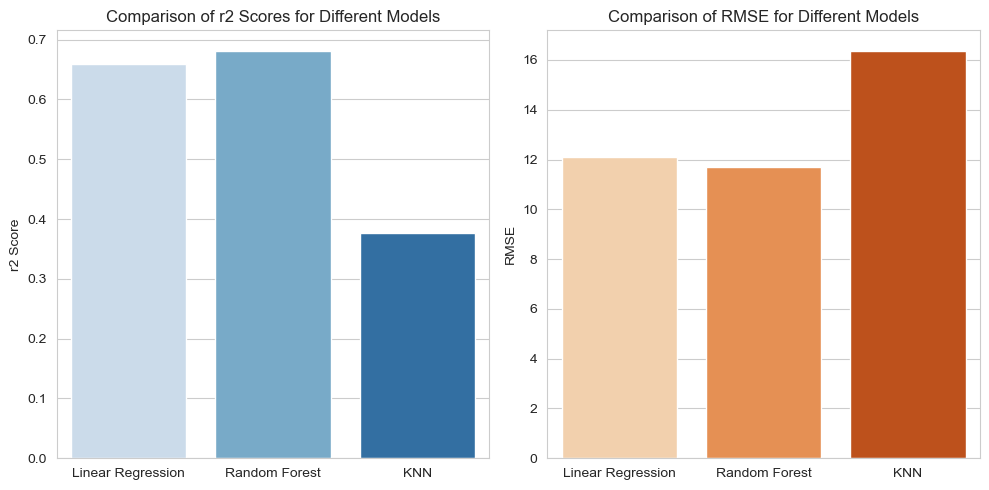

In [38]:
r2_values = [r2_lr_tot,r2_rf_tot,r2_knn_tot]
rmse_values = [rmse_lr_tot,rmse_rf_tot,rmse_knn_tot]
models = ['Linear Regression', 'Random Forest','KNN']
data = pd.DataFrame({'Model': models, 'r2 Score': r2_values, 'RMSE': rmse_values})
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
sns.barplot(x='Model', y='r2 Score', data=data, ax=ax1, palette='Blues')
ax1.set_xlabel('')
ax1.set_ylabel('r2 Score')
ax1.set_title('Comparison of r2 Scores for Different Models')
sns.barplot(x='Model', y='RMSE', data=data, ax=ax2, palette='Oranges')
ax2.set_xlabel('')
ax2.set_ylabel('RMSE')
ax2.set_title('Comparison of RMSE for Different Models')
plt.tight_layout()
plt.show()

# Mesure de la dérive de variables catégorielles.

Pour deux distributions de probabilités discrètes $P$ et $Q$, la **divergence de Kullback–Leibler** de $P$ par rapport à $Q$ est définie par:

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$


On définit la **divergence de Jensen-Shannon** comme une version lisse et symétrique de la divergence de Kullback-Leiber donnée par la formule suivante:

$${\rm JSD}(P \parallel Q)= \frac{1}{2}D(P \parallel M)+\frac{1}{2}D(Q \parallel M)$$

où $M=\frac{1}{2}(P+Q)$

### Exemple de calcul de $D_\text{KL}(P \parallel Q)$ : 

Soient $P$ =`[0.2, 0.3, 0.5]` et $Q$ =`[0.2, 0.4, 0.4]` deux vecteurs définissant une loi de probabilité discrete. Alors : 

$$
\begin{equation}
\begin{split}
D_\text{KL}(P \parallel Q) & = P(0) \log\left(\frac{P(0)}{Q(0)}\right)
                             + P(1) \log\left(\frac{P(1)}{Q(1)}\right)
                             + P(2) \log\left(\frac{P(2)}{Q(2)}\right)\\ \\
                           & = 0.2 \log\left(\frac{0.2}{0.2}\right)
                             + 0.3 \log\left(\frac{0.3}{0.4}\right)
                             + 0.5 \log\left(\frac{0.5}{0.4}\right) \\ \\
                           & = 0.02526...
\end{split}
\end{equation}
$$

### Exercice

* Implémenter des fonctions nommées **`KLDivergence(P, Q)`** et **`JSDivergence(P, Q)`** permettant de calculer les métriques définies ci-dessus.

**Conseils**:
* Utiliser la librairie Numpy permettant de facilement effectuer des calculs d'algèbre linéaire.

In [39]:
#Cette ligne de code utilise le module warnings de Python pour ignorer les avertissements de catégorie DeprecationWarning
import warnings
warnings.filterwarnings('ignore')

In [40]:
P = np.array([0.2, 0.3, 0.5])
Q = np.array([0.2, 0.4, 0.4])

def KLDivergence(P, Q):
    # S'assurer que les entrées sont des NumPy 1D array comme tout notre calcule est implémenté dans numpy
    P = np.asarray(P, dtype=np.float)
    Q = np.asarray(Q, dtype=np.float)
    
    # Vérification que les deux tableaux ont la même taille
    if P.shape != Q.shape:
        raise ValueError('Les tableaux doivent être de même taille.')
    e=0.00000000000000000000000000000000000000001    
    # Calcule de la divergence de Kullback-Leibler
    kl_div = np.sum(P * np.log((P+e) / (Q+e)))  # + e juste pour éviter les erreurs log(0) ou diviser par 0 
                                                # sans ça on aura des valeur manquntes pour certaines variables comme Seniority       
    return kl_div

def JSDivergence(P, Q):
    # Calculer M
    M = 0.5 * (P + Q)
    
    # Calcule de la divergence de Kullback-Leibler pour chaque distribution par rapport à M
    kl_PM = KLDivergence(P, M)
    kl_QM = KLDivergence(Q, M)
    
    # Calcule de la distance de Jensen-Shannon
    js_div = 0.5 * (kl_PM + kl_QM)
    
    return js_div


* Lancer la cellule suivante pour tester votre fonction.

In [41]:
print("K-L Divergence:", KLDivergence(P, Q))
print("J-S Divergence:", JSDivergence(P, Q))

K-L Divergence: 0.02526715392157057
J-S Divergence: 0.006367198333995731


# Mesure de la dérive de variables quantitatives.

Soit $P$ une mesure empirique d'échantillons $X_1, \ldots, X_n
$ et $Q$ une mesure empirique d'échantillons $Y_1, \ldots, Y_n$, on définit la **Distance de Wasserstein** d'ordre $p$ par la fonction suivante :

$$W_p(P, Q) = \left( \frac{1}{n}\sum_{i=1}^n \|X_{(i)} - Y_{(i)}\|^p \right)^{1/p}$$

où $X_{(1)}, \ldots, X_{(n)}$ et $Y_{(1)}, \ldots, Y_{(n)}$ sont les [**statistiques d'ordre**](https://en.wikipedia.org/wiki/Order_statistic#Notation_and_examples) des échantillons $X$ et $Y$ et $p$ un nombre entier positif.

### Exercice

* Implémenter une fonction nommée **`WassersteinDistance(X, Y, p)`** permettant de calculer cette métrique à l'ordre **`p`** à partir de **deux échantillons** **`X`** et **`Y`** que l'on supposera de même longueur.

**Conseils**:
* Vous pouvez trier les échantillons pour obtenir les statistiques d'ordre.

In [42]:
def WassersteinDistance(X, Y, p):
    # S'assurer que les entrées sont des NumPy 1D array comme tout notre calcule est implémenté dans numpy
    X = np.asarray(X, dtype=np.float)
    Y = np.asarray(Y, dtype=np.float)
    
    # Vérification que les deux tableaux ont la même taille
    if X.shape != Y.shape:
        raise ValueError('Les tableaux doivent être de même taille.')
    
    # Trier les tableaux en ordre croissant
    X_sort = np.sort(X)
    Y_sort = np.sort(Y)
    
    # Calculer la distance de Wasserstein
    wasserstein_dist = np.power(np.sum(np.power(np.abs(X_sort - Y_sort), p)) / X.shape[0], 1/p)
    
    return wasserstein_dist


* Lancer la cellule suivante pour tester votre fonction.

In [43]:
X = np.random.beta(2, 6, 100)

Y = np.random.beta(3, 6, 100)

WassersteinDistance(X, Y, 2)

0.10249882924696585

In [44]:
a=np.array([1,2,3,4])
b=np.array([29,39,49,59])

a=a/sum(a)
b=b/sum(b)

WassersteinDistance(a,b,2)

0.048278740423290924

# Étude de la dérive du modèle.

* En vous appuyant sur les métriques définies précédemment, illustrez et analysez visuellement la **dérive des données** ainsi que **la dérive du modèle** sur les périodes **1 à 3**. 


* Commenter les visualisations et déterminer si le modèle doit être mis à jour ou si sa performance est toujours acceptable. 

**Conseils**:
* Vous serez évalué sur **la rigueur et le soin** que vous donnerez à votre analyse, et sur **vos capacités à synthéthiser votre étude**. Vous ne serez pas évalué sur vos conclusions.


* Vous pouvez normaliser les données par rapport aux **moyennes et variances que vous calculerez sur la période 0** pour que les distances de Wasserstein pour différentes variables soient facilement comparables.

### Fonction de Calcule:

Dans cette partie de test, nous avons créé une fonction qui facilite le calcul des distances de dérive entre les variables de différents ensembles de données tout en normalisant le travail. En effet, ces distances nécessitent la normalisation des variables, comme expliqué dans le notebook.

In [45]:
# Fonction pour normaliser un variable avec numpy
def numpy_norm_dist(var):
    return var/sum(var)


def numpy_norm_cont(var):
    return (var-np.mean(var))/np.std(var)
    
# Fonction pour calculer les distances entre les variables dans différents ensembles de données
def cal_derive_var(X,p=2):
    # Extraire la variable X de chaque ensemble de données
    dist0=df0[X].to_numpy()
    dist1=df1[X].to_numpy()
    dist2=df2[X].to_numpy()
    dist3=df3[X].to_numpy()


    # Calculer la distance entre les variables avec la méthode appropriée en fonction de leur type
    if df0[X].dtype=='int64':
        # on normalise les variable pour qu'elle deviennent des vecteurs définissant une loi de probabilité discrete
        dist0=numpy_norm_dist(dist0)
        dist1=numpy_norm_dist(dist1)
        dist2=numpy_norm_dist(dist2)
        dist3=numpy_norm_dist(dist3)
        
        dev01=JSDivergence(dist0,dist1)
        dev02=JSDivergence(dist0,dist2)
        dev03=JSDivergence(dist0,dist3)
        dev12=JSDivergence(dist1,dist2)
        dev13=JSDivergence(dist1,dist3)
        dev23=JSDivergence(dist2,dist3)
        d=pd.DataFrame({'dev01': dev01, 'dev02': dev02, 'dev03': dev03,
                        'dev12': dev12, 'dev13': dev13, 'dev23': dev23},index=['JSDivergence'])
    
    else:
        # on pouvez normalise les données par rapport aux moyennes et variances
        # pour que les distances de Wasserstein pour différentes variables soient facilement comparables.
        dist0=numpy_norm_cont(dist0)
        dist1=numpy_norm_cont(dist1)
        dist2=numpy_norm_cont(dist2)
        dist3=numpy_norm_cont(dist3)

        dev01=WassersteinDistance(dist0,dist1,p)
        dev02=WassersteinDistance(dist0,dist2,p)
        dev03=WassersteinDistance(dist0,dist3,p)
        dev12=WassersteinDistance(dist1,dist2,p)
        dev13=WassersteinDistance(dist1,dist3,p)
        dev23=WassersteinDistance(dist2,dist3,p)
        d=pd.DataFrame({'dev01': dev01, 'dev02': dev02, 'dev03': dev03,
                        'dev12': dev12, 'dev13': dev13, 'dev23': dev23},index=['WassersteinDistance'])
    
    return d


In [46]:
# juste s'assurer que nos methodes de calcule des distances marche avec toutes les variables.
for i in df0.columns:
    if df0[i].dtype!='O':
        print(f"\n{i}:\n{cal_derive_var(i)}\n")        


Age:
                 dev01     dev02     dev03     dev12     dev13     dev23
JSDivergence  0.011193  0.010768  0.010979  0.011214  0.010421  0.010209


Seniority:
                dev01     dev02     dev03     dev12     dev13     dev23
JSDivergence  0.40157  0.382949  0.363432  0.331194  0.319033  0.298862


Orders:
                 dev01     dev02     dev03     dev12     dev13     dev23
JSDivergence  0.103172  0.109149  0.131758  0.108718  0.124703  0.127584


Items:
                 dev01     dev02     dev03     dev12     dev13     dev23
JSDivergence  0.049591  0.046362  0.049151  0.055816  0.055998  0.055896


AverageDiscount:
                        dev01     dev02     dev03     dev12     dev13  \
WassersteinDistance  0.040114  0.043975  0.047264  0.061734  0.052525   

                        dev23  
WassersteinDistance  0.036804  


BrowsingTime:
                        dev01     dev02     dev03     dev12     dev13  \
WassersteinDistance  0.065174  0.111788  0.140394  0.072895  

### La dérive des données:

Nous allons diviser notre analyse des distances en trois catégories : les variables discrètes, les variables continues et les Variables Catégorielles. En effet, la distance de Wasserstein est adaptée pour les variables continues, tandis que la divergence de Jensen-Shannon est adaptée pour les variables discrètes. Il est important de prendre en compte cette différence car les deux distances ne sont pas directement comparables entre elles.

#### 1. les Variables Discrètes:

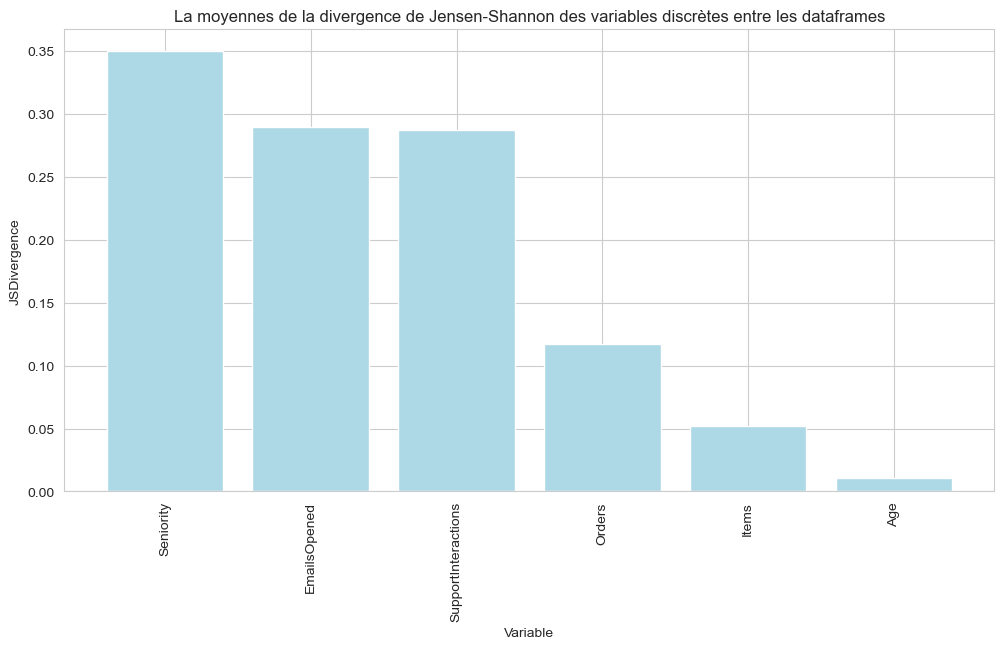

In [63]:
# Créer une liste des dataframes et de leurs étiquettes correspondantes
dfs = [df0, df1, df2, df3]
labels = ['df0', 'df1', 'df2', 'df3']

# Créer une matrice vide pour stocker les distances par paires
n_dfs = len(dfs)
dist_matrix = pd.DataFrame(index=labels, columns=labels)

# Itérer sur toutes les paires de dataframes et calculer la distance
for i in range(n_dfs):
    for j in range(i+1, n_dfs):
        # Calculer la distance entre les dataframes pour chaque variable
        dists = []
        for var in df0.columns:
            if df0[var].dtype == 'int64':
                dists.append(cal_derive_var(var, p=2)['dev{}{}'.format(i,j)].values[0])
        # Stocker la distance moyenne entre les dataframes
        dist_matrix.iloc[i,j] = np.mean(dists)
        dist_matrix.iloc[j,i] = np.mean(dists)

# Calculer la distance entre les dataframes pour chaque variable individuellement
var_dists = pd.DataFrame(columns=['variable', 'JSDivergence'])
for var in df0.columns:
    if df0[var].dtype == 'int64':
        dists = []
        for i in range(n_dfs):
            for j in range(i+1, n_dfs):
                dists.append(cal_derive_var(var, p=2)['dev{}{}'.format(i,j)].values[0])
        var_dists = var_dists.append({'variable': var, 'JSDivergence': np.mean(dists)}, ignore_index=True)

# Classer les variables selon leur contribution à la distance totale
var_dists = var_dists.sort_values('JSDivergence', ascending=False)

# Créer une figure en barres pour visualiser les distances variables
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(var_dists['variable'], var_dists['JSDivergence'], color='lightblue')

# Ajouter un titre et des étiquettes aux axes
ax.set_title('La moyennes de la divergence de Jensen-Shannon des variables discrètes entre les dataframes')
ax.set_xlabel('Variable')
ax.set_ylabel('JSDivergence')

# Faire pivoter les étiquettes des axes x pour les rendre plus lisibles
plt.xticks(rotation=90)

# Afficher la figure
plt.show()


D'après les résultats obtenus  peuvent suggérer que les comportements et préférences des clients ont changé avec le temps.

En termes de variables spécifiques, nous pouvons remarquer que la variable **`Seniority`** a la plus grande distance de divergence de Jensen-Shannon, ce qui signifie que la distribution des valeurs de cette variable diffère le plus entre les ensembles de données. Cela peut suggérer que la relation entre l'âge et la durée d'inscription des clients a évolué avec le temps.

De même, les variables **`EmailsOpened`** et **`SupportInteractions`** ont également des distances de divergence de Jensen-Shannon relativement élevées, ce qui peut indiquer que l'engagement des clients avec les emails et le support a également changé avec le temps.

En revanche, les variables **`Orders`** et **`Items`** ont des distances de divergence de Jensen-Shannon relativement faibles, ce qui suggère que la distribution des valeurs de ces variables est relativement similaire entre les ensembles de données. Cela peut indiquer une certaine stabilité dans le comportement des clients en termes de fréquence et de quantité d'achats.

Il convient de noter que la variable **`Age`** a la plus faible distance de divergence de Jensen-Shannon, ce qui suggère que la distribution des âges des clients est relativement stable au fil du temps.

En conclusion, les résultats de la divergence de Jensen-Shannon montrent des différences significatives entre les ensembles de données appartenant à différentes périodes de temps, en particulier en ce qui concerne les variables **`Seniority`**, **`EmailsOpened`** et **`SupportInteractions`**. Ces différences peuvent indiquer un changement dans les comportements et préférences des clients avec le temps.

<AxesSubplot:>

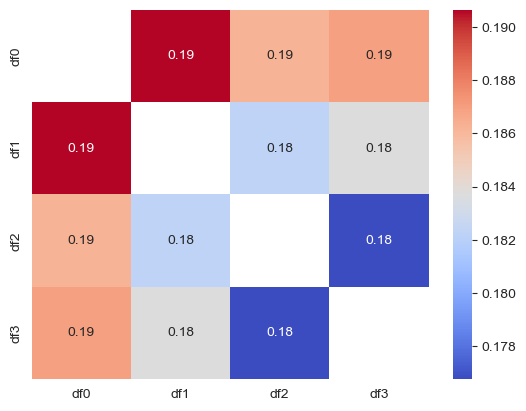

In [48]:
# Visualiser la matrice de distance sous forme de carte de chaleur
sns.heatmap(dist_matrix.astype(float), annot=True, cmap='coolwarm')

Les résultats de la matrice de confusion montrent que les quatre ensembles de données sont différents les uns des autres avec une moyenne de <b>0,185</b> pour la divergence de Jensen-Shannon. Cette valeur représente la distance moyenne entre les distributions de probabilité des données. Plus la distance est élevée, plus les distributions sont différentes. Ainsi, une valeur moyenne de 0,185 indique que les ensembles de données présentent des différences significatives entre eux, mais qu'elles ne sont pas extrêmes. Cela peut indiquer que les ensembles de données ont des caractéristiques similaires, mais qu'il y a également des différences notables qui doivent être prises en compte lors de l'analyse.

#### 2. les Variables Continue:

<b> Pourquoi on a choisit la valeur 2 par défaut pour le paramètre p? </b>

En général, pour des données de type continue, la distance de Wasserstein avec p=2 est couramment utilisée car elle prend en compte la distribution complète de la variable et permet de capturer les différences de forme et d'écart-type entre les distributions.



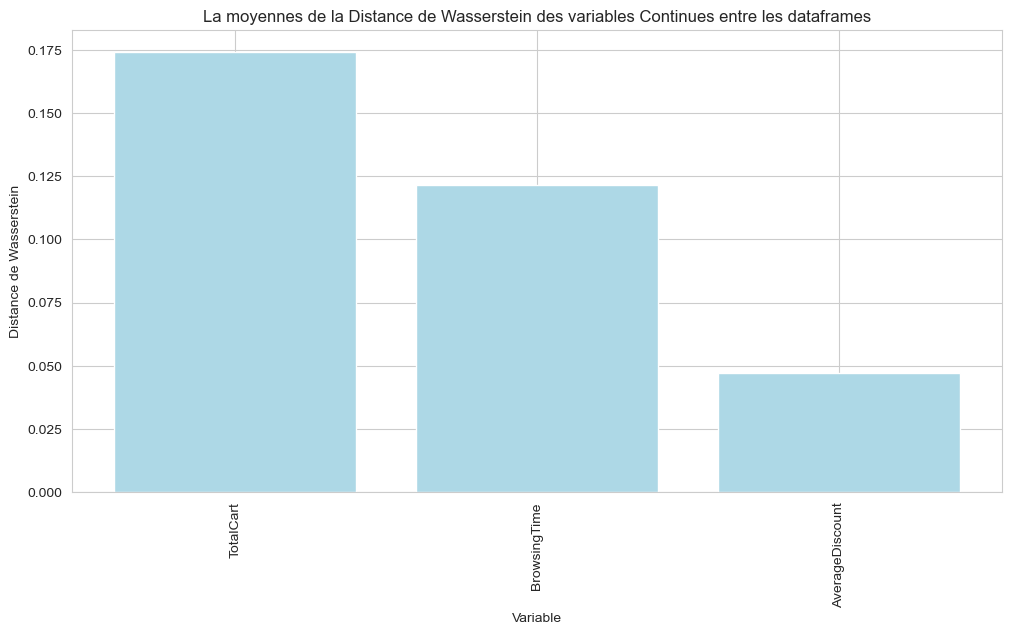

In [67]:
# Créer un DataFrame vide pour stocker les distances de Wasserstein
var_dists = pd.DataFrame(columns=['variable', 'WassersteinDistance'])

# Itérer sur chaque variable et calculer la distance de Wasserstein
for var in df0.columns:
    if df0[var].dtype == 'float64':
        dists = []
        for i in range(n_dfs):
            for j in range(i+1, n_dfs):
                dists.append(cal_derive_var(var, p=2)['dev{}{}'.format(i,j)].values[0])
        var_dists = var_dists.append({'variable': var, 'WassersteinDistance': np.mean(dists)}, ignore_index=True)

# Classer les variables selon leur contribution à la distance totale
var_dists = var_dists.sort_values('WassersteinDistance', ascending=False)

# Créer une figure en barres pour visualiser les distances variables
plt.figure(figsize=(12,6))
plt.bar(var_dists['variable'], var_dists['WassersteinDistance'], color='lightblue')
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Distance de Wasserstein')
plt.title('La moyennes de la Distance de Wasserstein des variables Continues entre les dataframes')
plt.show()


Baser sur ces résultats, ayant des valeurs relativement petites pour la distance de Wasserstein (maximum de 0.17), on peut penser que les variables n'ont pas vraiment de différences significatives entre les dataframes. Cette hypothèse est renforcée par le fait que les valeurs de distance de Wasserstein sont très proches de zéro, indiquant qu'il n'y a pas de différences significatives entre les distributions de probabilité des données. Cela peut être dû à plusieurs facteurs, tels que l'échantillonnage aléatoire des données ou la similarité des distributions de probabilité entre les dataframes. Dans l'ensemble, il est peu probable que ces variables soient des facteurs clés pour expliquer les différences entre les dataframes.

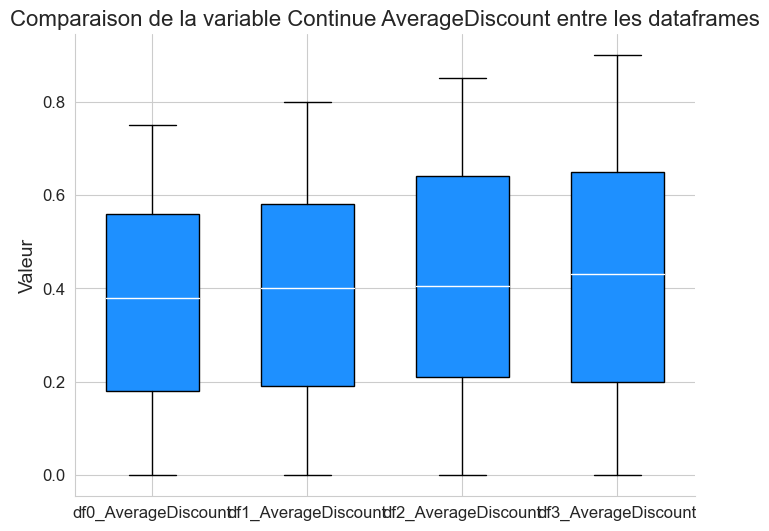

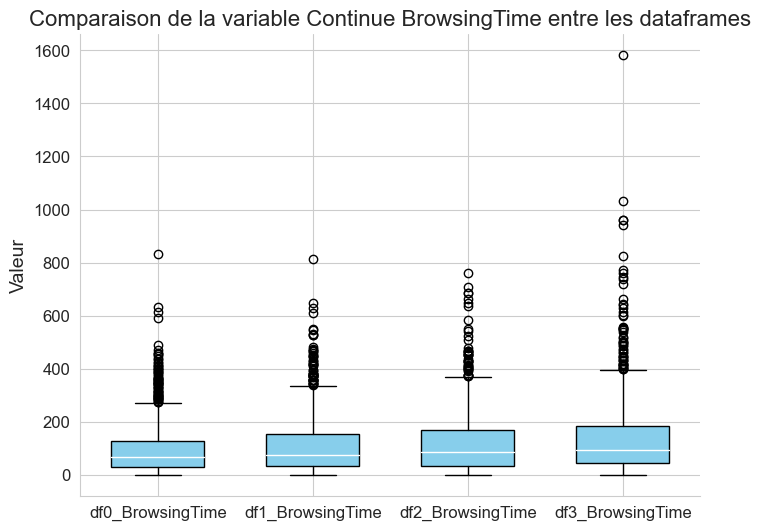

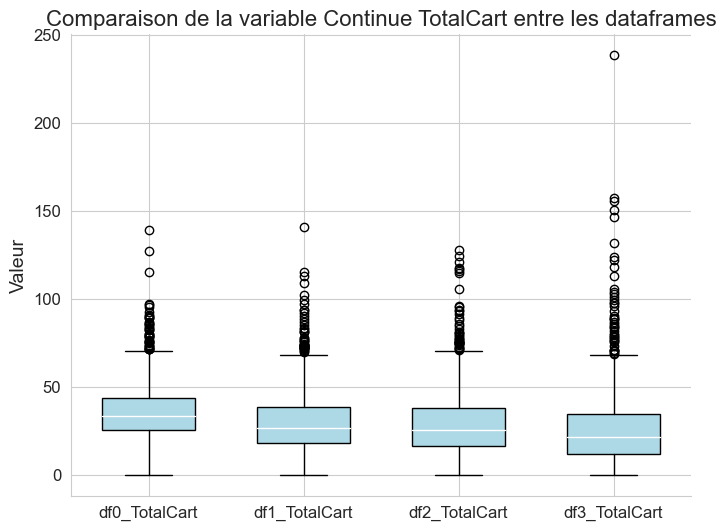

In [108]:
# Définir les couleurs pour chaque variable
couleurs = {'AverageDiscount': 'dodgerblue', 'BrowsingTime': 'Skyblue', 'TotalCart': 'lightblue'}

# Créer des boxplots pour chaque variable et les ajouter à la figure
for var in ['AverageDiscount', 'BrowsingTime', 'TotalCart']:
    fig, ax = plt.subplots(figsize=(8, 6))
    box0 = ax.boxplot(df0[var], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=couleurs[var], color='black'), medianprops=dict(color='white'))
    box1 = ax.boxplot(df1[var], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor=couleurs[var], color='black'), medianprops=dict(color='white'))
    box2 = ax.boxplot(df2[var], positions=[3], widths=0.6, patch_artist=True, boxprops=dict(facecolor=couleurs[var], color='black'), medianprops=dict(color='white'))
    box3 = ax.boxplot(df3[var], positions=[4], widths=0.6, patch_artist=True, boxprops=dict(facecolor=couleurs[var], color='black'), medianprops=dict(color='white'))
    
    # Personnaliser la mise en page
    ax.set_title(f'Comparaison de la variable Continue {var} entre les dataframes', fontsize=16)
    ax.set_ylabel('Valeur', fontsize=14)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['df0_'+var, 'df1_'+var, 'df2_'+var, f'df3_{var}'], fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.show()


En comparant les résultats entre les quatre périodes, on a trouvé que les résultats de la distance de Wasserstein qu'on a eu sont logiques car les valeurs de ces variables continues ne varient pas beaucoup entre les 4 dataframes. Les différences se situent principalement au niveau des outliers, ce qui n'a pas vraiment d'importance car cela ne reflète pas la distribution des valeurs de ces variables. 


#### 3. les Variables Catégorielles:

Dans cette partie, on va vérifier si la distribution de la variable catégorielle **`TopCategory`** est similaire sur les quatre périodes de temps. Pour cela, nous allons créer un diagramme en barres qui compare chaque valeur unique sur les quatre dataframes. Si nous constatons des changements significatifs dans la distribution de la variable, nous poursuivrons en effectuant une analyse de dérive.

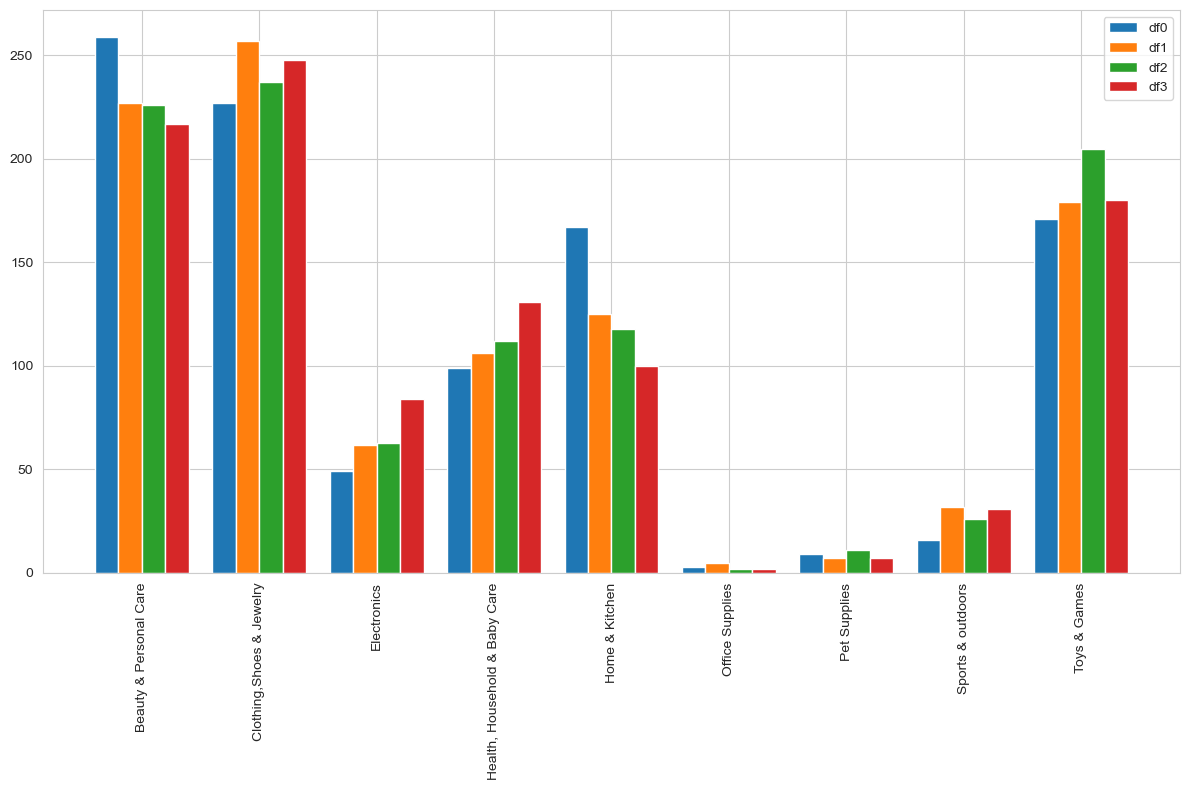

In [51]:
dfs = [df0, df1, df2, df3]  

labels = sorted(df0['TopCategory'].unique())

# Préparation des données pour les graphiques
counts_list = []

for df in dfs:
    counts = df['TopCategory'].value_counts()
    counts = counts.reindex(labels)
    counts_list.append(counts)

# Création des graphiques
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
bar_width = 0.2
for i, (counts) in enumerate(counts_list):
    ax.bar(np.arange(len(counts)) + i*bar_width, counts, width=bar_width, color=colors[i], label=f'df{i}')
    ax.set_xticks(np.arange(len(counts)) + (len(counts_list)-1)*bar_width/2)
    ax.set_xticklabels(labels, rotation=90)
    #ax.set_ylim([0, 1])
    ax.grid(axis='y')
    ax.legend()

plt.tight_layout()
plt.show()

L'analyse des résultats de ce graphique en barres montre des changements significatifs dans la distribution de chaque valeur unique entre les différentes périodes de temps. Par exemple, la <b>valeur Office Supplies </b> pour df1 est presque deux fois plus élevée que celle des autre dataframes. Il convient de noter que nous comparons approximativement les changements de hauteur entre le graphique en barres de chaque valeur unique suivant les dataframes. Ainsi, il y a des changements pour Beauty & Personal Care, mais ils ne sont pas aussi significatifs que ceux pour Office Supplies, car la différence est comparée à la taille de la même valeur unique dans les autres dataframes.



Après avoir analysé ce graphique, nous avons constaté l'importance de calculer la dérive des valeurs de la variable **`TopCategory`**. Cependant, notre fonction de calcul ne prend pas en charge les variables catégoriques. Pour résoudre ce problème, nous avons apporté quelques modifications :

1. Nous avons créé des dummies pour la variable **`TopCategory`** pour chaque dataframe et les avons nommées : <b>per0, per1, per2</b> et <b>per3</b>.


2. Nous avons créé une nouvelle version de la fonction <b>cal_derive_var</b> qui résout notre problème en calculant la JSDivergence pour chaque valeur unique sur les 4 périodes de temps et l'avons appelée <b>cal_derive_var_cat</b>.


3. Nous avons visualisé les résultats des calculs de dérive pour chaque valeur unique de la variable **`TopCategory`**.

In [52]:
per0=pd.get_dummies(df0['TopCategory'])
per1=pd.get_dummies(df1['TopCategory'])
per2=pd.get_dummies(df2['TopCategory'])
per3=pd.get_dummies(df3['TopCategory'])

In [53]:
# Fonction pour calculer les distances entre les variables dans différents ensembles de données
def cal_derive_var_cat(X):
    # Extraire la variable X de chaque ensemble de données
    dist0=per0[X]
    dist1=per1[X]
    dist2=per2[X]
    dist3=per3[X]
    # on normalise la variable et la transforme d'une pandas series à un NumPy 1D array
    dist0=numpy_norm_dist(dist0)
    dist1=numpy_norm_dist(dist1)
    dist2=numpy_norm_dist(dist2)
    dist3=numpy_norm_dist(dist3)
    
    # Calculer la distance entre les variables avec la méthode appropriée en fonction de leur type
        
    dev01=JSDivergence(dist0,dist1)
    dev02=JSDivergence(dist0,dist2)
    dev03=JSDivergence(dist0,dist3)
    dev12=JSDivergence(dist1,dist2)
    dev13=JSDivergence(dist1,dist3)
    dev23=JSDivergence(dist2,dist3)
    d=pd.DataFrame({'dev01': dev01, 'dev02': dev02, 'dev03': dev03,
                    'dev12': dev12, 'dev13': dev13, 'dev23': dev23},index=['JSDivergence'])
  
    return d

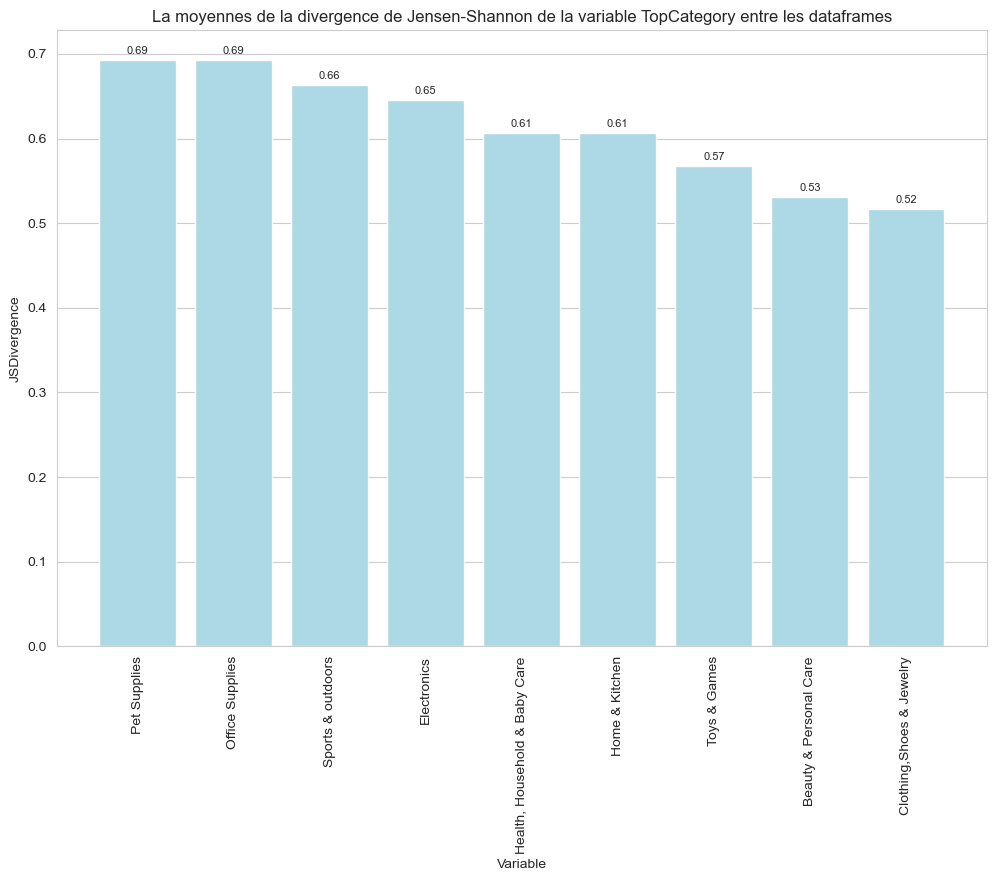

In [84]:
# Calculer la divergence de Jensen-Shannon pour chaque paire de dataframes
var_dists = pd.DataFrame(columns=['variable', 'JSDivergence'])
for var in per0.columns:
    dists = []
    for i in range(n_dfs):
        for j in range(i+1, n_dfs):
            dists.append(cal_derive_var_cat(var)['dev{}{}'.format(i,j)].values[0])
    var_dists = var_dists.append({'variable': var, 'JSDivergence': np.mean(dists)}, ignore_index=True)

# Classer les variables selon leur contribution à la distance totale
var_dists = var_dists.sort_values('JSDivergence', ascending=False)

# Créer un graphique en barres pour visualiser les distances variables
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(var_dists['variable'], var_dists['JSDivergence'], color='lightblue')

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# Personnaliser la mise en page
ax.set_title('La moyennes de la divergence de Jensen-Shannon de la variable TopCategory entre les dataframes')
ax.set_xlabel('Variable')
ax.set_ylabel('JSDivergence')
ax.tick_params(axis='x', labelrotation=90)
ax.grid(axis='x')

plt.show()

Ces résultats représentent les dérives des différentes catégories de la variable **`TopCategory`** par rapport aux quatre ensembles de données mesurée par la distance de Jensen-Shannon (JSDivergence)

On peut observer que les catégories "Pet Supplies" et "Office Supplies" ont la plus grande dérive (0.69), ce qui signifie que leur distribution de probabilité est la plus différente entre les ensembles de données. Les catégories "Electronics", "Health, Household & Baby Care" et "Home & Kitchen" ont également une dérive relativement élevée, tandis que les catégories "Toys & Games" et "Clothing,Shoes & Jewelry" ont la dérive la plus faible.

Ces résultats suggèrent que la variable **`TopCategory`** peut être un facteur important pour la prédiction des étiquettes manquantes, car les différentes catégories ont des distributions de probabilité qui varient considérablement entre les ensembles de données.


<b>Ces résultats montrent que la dérive des données est principalement affectée par les variables discrètes qu'on a identifié précédemment **`Seniority`**, **`EmailsOpened`** et **`SupportInteractions`** et la variable **`TopCategory`** et que les variables continues n'ont pas affectée  la dérive des données.</b>

### La dérive du modèle:

Comme le modèle de <b> Random Forest Regression </b>était le meilleur modèle de régression ayant les meilleurs résultats suite à notre évaluation, dans cette partie, nous allons étudier la dérive de ces résultats, afin de voir à quel point les performances de ce modèle ont changé avec l'avancement dans le temps (entre les 3 périodes/dataframes). Nous allons ainsi évaluer l'impact du temps sur les prévisions de ce modèle et voir s'il est nécessaire de l'adapter pour maintenir sa performance dans le temps.


1. Dans cette partie, nous allons évaluer la dérive du modèle pour les périodes 1 à 3 en nous basant sur les résultats de prédiction que nous avons obtenus précédemment. Il est important de noter que les résultats de prédiction et les valeurs de la variable **`TotalCart`**  doivent être comparables.


2. Nous allons calculé la distance de Wasserstein entre les prédictions normalisées et les vraies valeurs normalisées de la variable cible en utilisant la fonction WassersteinDistance().


3. Nous allon comparé les distances de Wasserstein pour détecter une éventuelle dérive du modèle. Si les distances augmentent significativement d'une période à l'autre, cela peut indiquer que le modèle est en train de dériver.

In [55]:
pred1= numpy_norm_cont(y_pred_RF_1)
pred2= numpy_norm_cont(y_pred_RF_2)
pred3= numpy_norm_cont(y_pred_RF_3)

true1=numpy_norm_cont(df1['TotalCart'].to_numpy())
true2=numpy_norm_cont(df2['TotalCart'].to_numpy())
true3=numpy_norm_cont(df3['TotalCart'].to_numpy())

dist1= WassersteinDistance(pred1,true1,2)
dist2= WassersteinDistance(pred2,true2,2)
dist3=WassersteinDistance(pred3,true3,2)

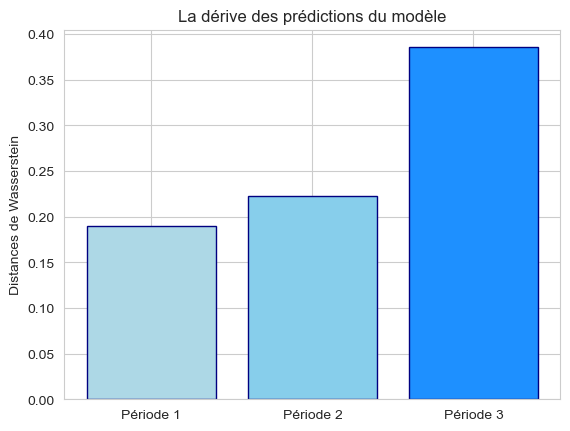

In [92]:
x = ['Période 1', 'Période 2', 'Période 3']
y = [dist1, dist2, dist3]
colors = ['lightblue', 'skyblue', 'dodgerblue']

fig, ax = plt.subplots()
ax.bar(x, y, color=colors, edgecolor='navy')

ax.set_title('La dérive des prédictions du modèle')
ax.set_ylabel('Distances de Wasserstein')

plt.show()

En se basant sur les résultats des distances de Wasserstein, on peut dire que la dérive du modèle est croissante. En effet, la distance entre les prédictions et les vraies valeurs pour la période 1 est la plus faible (0.188), tandis que pour la période 3 elle est la plus élevée (0.389). Cela peut indiquer que le modèle s'est moins bien adapté aux données de la période 3 par rapport aux périodes précédentes.

La distance de Wasserstein est un indicateur important de la qualité de prédiction du modèle, et si elle augmente au fil du temps, cela suggère que la performance du modèle se dégrade. Ainsi, la dérive du modèle est un problème qu'il est important de surveiller et de corriger pour assurer la fiabilité des prédictions.

#### Nouveau Modèle
Il serait intéressant d'entraîner le modèle sur les deux premières périodes (c'est-à-dire df0 et df1) et de comparer ses prédictions pour les périodes 2 et 3 avec les résultats du modèle initial entainé seulement sur la premiere période. Cela permettrait de déterminer si le modèle s'améliore dans la prédiction des périodes suivantes.

En faisant ça nous pourrons voir si le modèle a évolué et s'est amélioré dans la prédiction quand il est entainé sur des périodes plus récentes.

In [57]:
# On fusionne les deux premiers dataframes (df0 et df1)
train_df = pd.concat([df0,df1]).reset_index()

# On prépare les données pour l'entraînement : on utilise get_dummies pour 
# transformer les variables catégorielles en variables binaires
X_train_01=pd.get_dummies(train_df[predictors],drop_first=True)
y_train_01=train_df['TotalCart']

# On entraîne le modèle sur les données préparées
rf_model.fit(X_train_01, y_train_01)

# On utilise le modèle entraîné pour faire des prédictions sur la période 2
X_test=pd.get_dummies(df2[predictors],drop_first=True)

y_test=df2['TotalCart']

y_pred_RF_01_2 = rf_model.predict(X_test)

# On utilise le modèle entraîné pour faire des prédictions sur la période 3
X_test=pd.get_dummies(df3[predictors],drop_first=True)

y_test=df3['TotalCart']

y_pred_RF_01_3 = rf_model.predict(X_test)

In [58]:
pred_01_2= numpy_norm_cont(y_pred_RF_01_2)
pred_01_3= numpy_norm_cont(y_pred_RF_01_3)

dist_01_2= WassersteinDistance(pred_01_2,true2,2)
dist_01_3= WassersteinDistance(pred_01_3,true3,2)

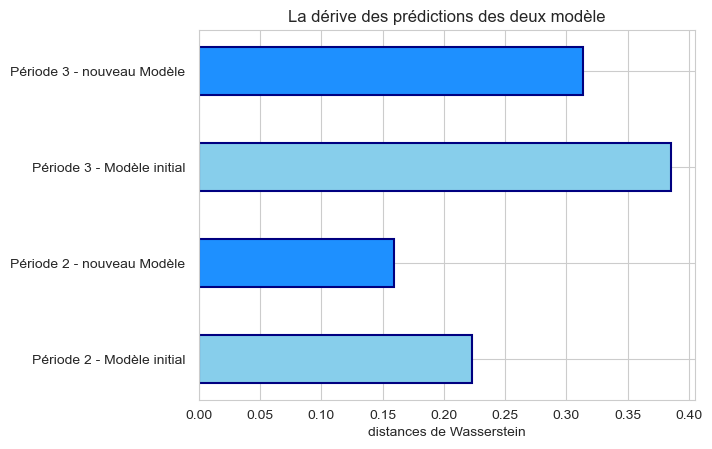

In [102]:
distances = [dist2, dist_01_2, dist3, dist_01_3]
labels = ['Période 2 - Modèle initial ', 'Période 2 - nouveau Modèle ', 'Période 3 - Modèle initial ', 'Période 3 - nouveau Modèle ']
colors = ['skyblue', 'dodgerblue', 'skyblue', 'dodgerblue']


fig, ax = plt.subplots()


ax.barh(np.arange(len(labels)), distances, height=0.5, color=colors, edgecolor='navy', linewidth=1.5)


ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)


ax.set_title('La dérive des prédictions des deux modèle')
ax.set_xlabel('distances de Wasserstein')


plt.show()

Nous avons observé que le modèle entraîné sur les périodes 0 et 1 a donné de meilleurs résultats que le modèle entraîné uniquement sur la période 0. Cela se traduit par une diminution de la distance de Wasserstein.

Cependant, ce gain de précision suggère également une dérive du modèle par rapport au temps. En effet, les caractéristiques des données évoluent au fil du temps, ce qui peut avoir un impact sur la capacité du modèle à prédire avec précision les valeurs cibles des données les plus récentes.

Il est donc important de surveiller régulièrement la performance du modèle et de le ré-entraîner avec des données plus récentes si la dérive devient apparente. 

En outre, l'analyse de la dérive des données a révélé que certaines variables discrètes telles que **`Seniority`**, **`EmailsOpened`** et **`SupportInteractions`** ainsi que la variable **`TopCategory`**, ont un impact significatif sur la dérive des données. Cela peut indiquer que ces variables ont un effet important sur la performance du modèle, et qu'il est important de les prendre en compte lors de l'ajustement du modèle.

# Conclusion:

Dans le cadre de ce projet, nous avons étudié la performance de trois modèles de régression pour prédire la variable TopCategory. Nous avons constaté que le modèle de random forest était le plus performant. Cependant, une analyse de la dérive du modèle a révélé une augmentation croissante de la distance de Wasserstein au fil du temps, indiquant une capacité de moins en moins bonne du modèle à s'adapter aux nouvelles données. Cette dérive peut être liée à une insuffisance d'ajustement du modèle aux variables qui ont une forte influence sur la dérive des données, notamment **`Seniority`**, **`EmailsOpened`**, **`SupportInteractions`** et **`TopCategory`**.

Afin d'améliorer la performance du modèle, nous recommandons d'inclure ces variables dans le modèle et de les ajuster correctement. Nous suggérons également de revoir la méthodologie de l'entraînement et de la validation du modèle en adoptant une approche de type <b> « rolling window »</b>. Enfin, nous recommandons de surveiller régulièrement la dérive du modèle et de mettre à jour le modèle si nécessaire pour maintenir sa performance au fil du temps.

En somme, cette étude met en évidence l'importance de surveiller la performance des modèles au fil du temps et de les ajuster régulièrement en fonction des nouvelles données. 

Je suis heureux d'avoir travaillé sur ce projet passionnant de data science et je suis honoré de présenter mes résultats pour votre test.

J'aimerai terminer mon projet avec une parole qui me semble de plus en plus vraie avec le temps:

In [60]:
#!pip install pyfiglet
from pyfiglet import Figlet

f = Figlet(font='big')
quote = "Without data you're just another person with an opinion !"
ascii_art = f.renderText(quote)

print(ascii_art)

__          ___ _   _                 _         _       _        
\ \        / (_) | | |               | |       | |     | |       
 \ \  /\  / / _| |_| |__   ___  _   _| |_    __| | __ _| |_ __ _ 
  \ \/  \/ / | | __| '_ \ / _ \| | | | __|  / _` |/ _` | __/ _` |
   \  /\  /  | | |_| | | | (_) | |_| | |_  | (_| | (_| | || (_| |
    \/  \/   |_|\__|_| |_|\___/ \__,_|\__|  \__,_|\__,_|\__\__,_|
                                                                 
                                                                 
                   _              _           _   
                  ( )            (_)         | |  
 _   _  ___  _   _|/ _ __ ___     _ _   _ ___| |_ 
| | | |/ _ \| | | | | '__/ _ \   | | | | / __| __|
| |_| | (_) | |_| | | | |  __/   | | |_| \__ \ |_ 
 \__, |\___/ \__,_| |_|  \___|   | |\__,_|___/\__|
  __/ |                         _/ |              
 |___/                         |__/               
                   _   _                                        